from https://keras.io/examples/generative/wgan_gp/

# 데이터 준비

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [2]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

noise_dim = 128

dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


11501568/11490434 [==============================] - 0s 0us/step
Number of examples: 60000
Shape of the images in the dataset: (28, 28)


# D 정의

In [3]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # 28x28 영상을 32x32로 만드릭 위해 padding 한다.
    x = ZeroPadding2D((2, 2))(img_input)
    x = conv_block(x,  64, (5, 5), use_dropout=False)
    x = conv_block(x, 128, (5, 5), use_dropout=True)
    x = conv_block(x, 256, (5, 5), use_dropout=True)
    x = conv_block(x, 512, (5, 5), use_dropout=False)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   1664        ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',   

# G 정의


In [4]:

def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bn=True,
    use_bias=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, )
    x = upsample_block(x,  64, )
    x = upsample_block(x,   1, activation=Activation("tanh"))
    # 생성된 이미지 32x32를 28x28로 만들기 위해 cropping한다.
    x = Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 4096)         524288      ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096)        16384       ['dense_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 4096)         0           ['batch_normalization[0][

# WGAN-GP 모델 정의

In [5]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # D 학습

        # D는 G에 비해 d_steps 배 학습함.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 에폭 마다 결과 보는 callback

In [6]:
import matplotlib.pyplot as plt

class GANMonitor(Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        print("epoch",epoch)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        plt.figure(figsize=(10, 3))
        for i in range(1, self.num_img):
            ax = plt.subplot(1, self.num_img, i)
            plt.imshow(generated_images[i-1].numpy().squeeze(), cmap="binary")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     img = keras.preprocessing.image.array_to_img(img)
        #     img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



# 학습


Epoch 1/100
118/118 [==============================] - ETA: 0s - d_loss: -16.3689 - g_loss: -18.3546epoch 0


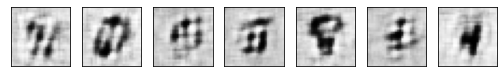

118/118 [==============================] - 53s 328ms/step - d_loss: -16.3709 - g_loss: -18.2709
Epoch 2/100
118/118 [==============================] - ETA: 0s - d_loss: -14.9858 - g_loss: -5.1504epoch 1


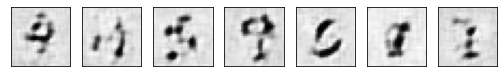

118/118 [==============================] - 39s 327ms/step - d_loss: -14.9835 - g_loss: -5.1192
Epoch 3/100
118/118 [==============================] - ETA: 0s - d_loss: -13.5841 - g_loss: -1.5358epoch 2


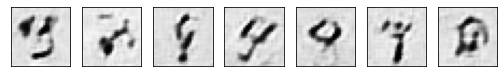

118/118 [==============================] - 39s 328ms/step - d_loss: -13.5798 - g_loss: -1.4830
Epoch 4/100
118/118 [==============================] - ETA: 0s - d_loss: -12.5347 - g_loss: 0.8255epoch 3


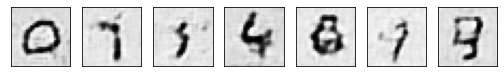

118/118 [==============================] - 39s 328ms/step - d_loss: -12.5359 - g_loss: 0.8370
Epoch 5/100
118/118 [==============================] - ETA: 0s - d_loss: -11.4245 - g_loss: 3.8512epoch 4


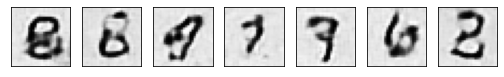

118/118 [==============================] - 39s 329ms/step - d_loss: -11.4277 - g_loss: 3.8547
Epoch 6/100
118/118 [==============================] - ETA: 0s - d_loss: -10.4752 - g_loss: 5.9006epoch 5


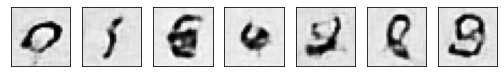

118/118 [==============================] - 39s 329ms/step - d_loss: -10.4786 - g_loss: 5.9151
Epoch 7/100
118/118 [==============================] - ETA: 0s - d_loss: -9.5938 - g_loss: 6.9140epoch 6


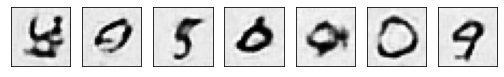

118/118 [==============================] - 39s 331ms/step - d_loss: -9.5874 - g_loss: 6.9291
Epoch 8/100
118/118 [==============================] - ETA: 0s - d_loss: -8.8418 - g_loss: 5.2350epoch 7


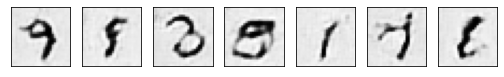

118/118 [==============================] - 39s 329ms/step - d_loss: -8.8384 - g_loss: 5.2105
Epoch 9/100
118/118 [==============================] - ETA: 0s - d_loss: -8.1610 - g_loss: 6.2019epoch 8


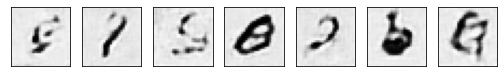

118/118 [==============================] - 39s 329ms/step - d_loss: -8.1612 - g_loss: 6.2165
Epoch 10/100
118/118 [==============================] - ETA: 0s - d_loss: -7.5065 - g_loss: 6.7890epoch 9


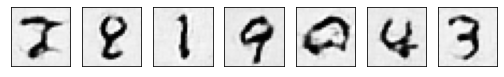

118/118 [==============================] - 39s 329ms/step - d_loss: -7.5052 - g_loss: 6.8055
Epoch 11/100
118/118 [==============================] - ETA: 0s - d_loss: -6.9478 - g_loss: 7.5774epoch 10


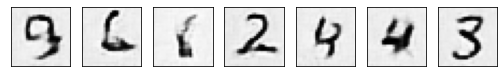

118/118 [==============================] - 39s 330ms/step - d_loss: -6.9371 - g_loss: 7.5722
Epoch 12/100
118/118 [==============================] - ETA: 0s - d_loss: -6.4686 - g_loss: 6.3548epoch 11


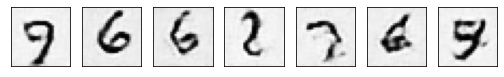

118/118 [==============================] - 39s 329ms/step - d_loss: -6.4532 - g_loss: 6.3278
Epoch 13/100
118/118 [==============================] - ETA: 0s - d_loss: -6.0153 - g_loss: 6.3473epoch 12


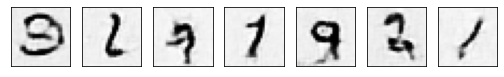

118/118 [==============================] - 39s 330ms/step - d_loss: -6.0170 - g_loss: 6.3615
Epoch 14/100
118/118 [==============================] - ETA: 0s - d_loss: -5.6288 - g_loss: 8.6960epoch 13


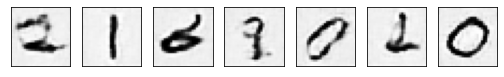

118/118 [==============================] - 39s 332ms/step - d_loss: -5.6456 - g_loss: 8.7180
Epoch 15/100
118/118 [==============================] - ETA: 0s - d_loss: -5.2612 - g_loss: 10.3508epoch 14


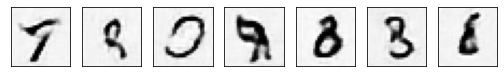

118/118 [==============================] - 39s 330ms/step - d_loss: -5.2598 - g_loss: 10.3286
Epoch 16/100
118/118 [==============================] - ETA: 0s - d_loss: -4.8690 - g_loss: 8.1152epoch 15


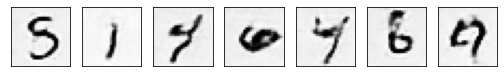

118/118 [==============================] - 39s 331ms/step - d_loss: -4.8695 - g_loss: 8.0967
Epoch 17/100
118/118 [==============================] - ETA: 0s - d_loss: -4.5325 - g_loss: 8.6169epoch 16


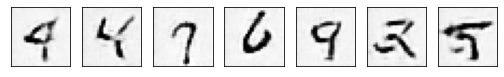

118/118 [==============================] - 39s 330ms/step - d_loss: -4.5434 - g_loss: 8.6214
Epoch 18/100
118/118 [==============================] - ETA: 0s - d_loss: -4.1771 - g_loss: 9.1409epoch 17


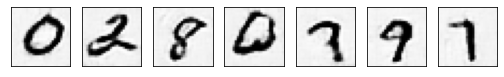

118/118 [==============================] - 39s 330ms/step - d_loss: -4.1834 - g_loss: 9.1639
Epoch 19/100
118/118 [==============================] - ETA: 0s - d_loss: -3.8970 - g_loss: 9.5192epoch 18


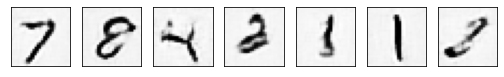

118/118 [==============================] - 39s 332ms/step - d_loss: -3.8828 - g_loss: 9.5058
Epoch 20/100
118/118 [==============================] - ETA: 0s - d_loss: -3.6584 - g_loss: 8.2866epoch 19


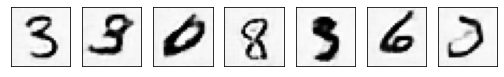

118/118 [==============================] - 39s 331ms/step - d_loss: -3.6633 - g_loss: 8.2816
Epoch 21/100
118/118 [==============================] - ETA: 0s - d_loss: -3.4412 - g_loss: 9.4838epoch 20


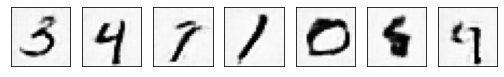

118/118 [==============================] - 39s 331ms/step - d_loss: -3.4537 - g_loss: 9.4847
Epoch 22/100
118/118 [==============================] - ETA: 0s - d_loss: -3.1907 - g_loss: 9.3430epoch 21


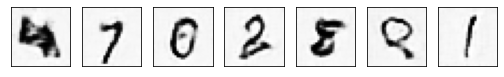

118/118 [==============================] - 39s 333ms/step - d_loss: -3.1818 - g_loss: 9.3336
Epoch 23/100
118/118 [==============================] - ETA: 0s - d_loss: -3.0499 - g_loss: 8.7420epoch 22


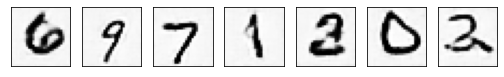

118/118 [==============================] - 39s 332ms/step - d_loss: -3.0623 - g_loss: 8.7494
Epoch 24/100
118/118 [==============================] - ETA: 0s - d_loss: -2.8373 - g_loss: 8.9627epoch 23


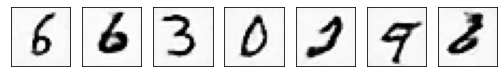

118/118 [==============================] - 39s 331ms/step - d_loss: -2.8401 - g_loss: 8.9742
Epoch 25/100
118/118 [==============================] - ETA: 0s - d_loss: -2.7214 - g_loss: 9.9783epoch 24


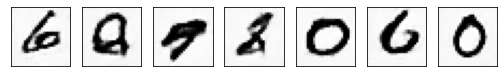

118/118 [==============================] - 39s 332ms/step - d_loss: -2.7244 - g_loss: 9.9941
Epoch 26/100
118/118 [==============================] - ETA: 0s - d_loss: -2.5123 - g_loss: 10.4723epoch 25


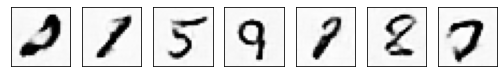

118/118 [==============================] - 39s 331ms/step - d_loss: -2.5141 - g_loss: 10.4726
Epoch 27/100
118/118 [==============================] - ETA: 0s - d_loss: -2.3892 - g_loss: 10.9356epoch 26


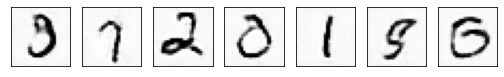

118/118 [==============================] - 39s 332ms/step - d_loss: -2.3957 - g_loss: 10.9735
Epoch 28/100
118/118 [==============================] - ETA: 0s - d_loss: -2.2384 - g_loss: 10.3176epoch 27


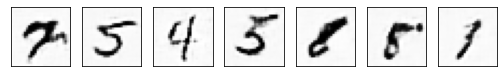

118/118 [==============================] - 39s 332ms/step - d_loss: -2.2449 - g_loss: 10.3109
Epoch 29/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1216 - g_loss: 11.6870epoch 28


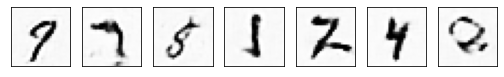

118/118 [==============================] - 39s 334ms/step - d_loss: -2.1290 - g_loss: 11.6828
Epoch 30/100
118/118 [==============================] - ETA: 0s - d_loss: -2.0800 - g_loss: 12.3042epoch 29


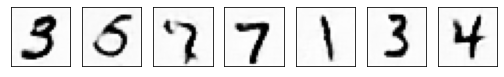

118/118 [==============================] - 39s 331ms/step - d_loss: -2.0792 - g_loss: 12.3160
Epoch 31/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8909 - g_loss: 13.5220epoch 30


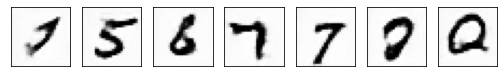

118/118 [==============================] - 39s 331ms/step - d_loss: -1.8902 - g_loss: 13.5076
Epoch 32/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8701 - g_loss: 12.1162epoch 31


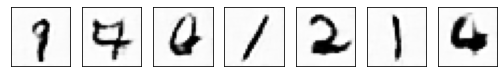

118/118 [==============================] - 39s 331ms/step - d_loss: -1.8729 - g_loss: 12.1327
Epoch 33/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7921 - g_loss: 11.6353epoch 32


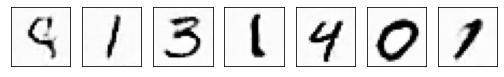

118/118 [==============================] - 39s 332ms/step - d_loss: -1.7787 - g_loss: 11.6157
Epoch 34/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8200 - g_loss: 12.4223epoch 33


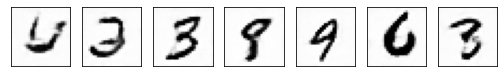

118/118 [==============================] - 39s 332ms/step - d_loss: -1.8375 - g_loss: 12.4157
Epoch 35/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7646 - g_loss: 12.0732epoch 34


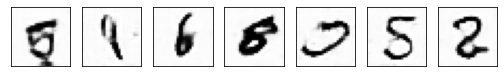

118/118 [==============================] - 39s 331ms/step - d_loss: -1.7749 - g_loss: 12.0800
Epoch 36/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6134 - g_loss: 13.6727epoch 35


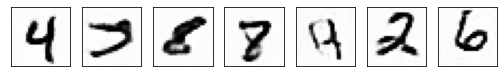

118/118 [==============================] - 39s 331ms/step - d_loss: -1.6080 - g_loss: 13.7048
Epoch 37/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4787 - g_loss: 16.0271epoch 36


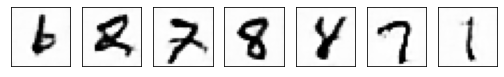

118/118 [==============================] - 39s 333ms/step - d_loss: -1.4947 - g_loss: 16.0130
Epoch 38/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5473 - g_loss: 13.7957epoch 37


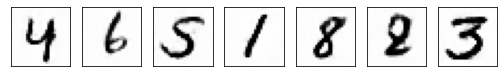

118/118 [==============================] - 39s 331ms/step - d_loss: -1.5512 - g_loss: 13.7792
Epoch 39/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5292 - g_loss: 16.4848epoch 38


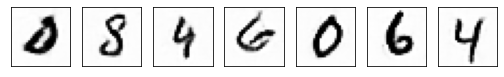

118/118 [==============================] - 39s 331ms/step - d_loss: -1.5502 - g_loss: 16.5802
Epoch 40/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3653 - g_loss: 16.6031epoch 39


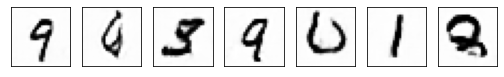

118/118 [==============================] - 39s 330ms/step - d_loss: -1.3762 - g_loss: 16.5771
Epoch 41/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4390 - g_loss: 13.3198epoch 40


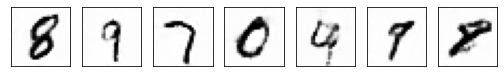

118/118 [==============================] - 39s 331ms/step - d_loss: -1.4382 - g_loss: 13.3639
Epoch 42/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5689 - g_loss: 13.6794epoch 41


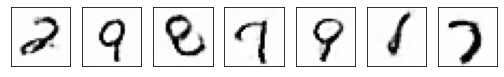

118/118 [==============================] - 39s 333ms/step - d_loss: -1.5744 - g_loss: 13.6711
Epoch 43/100
118/118 [==============================] - ETA: 0s - d_loss: -1.2624 - g_loss: 11.6501epoch 42


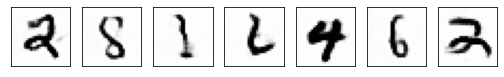

118/118 [==============================] - 39s 332ms/step - d_loss: -1.2688 - g_loss: 11.6239
Epoch 44/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3597 - g_loss: 13.2759epoch 43


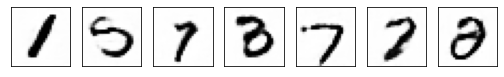

118/118 [==============================] - 39s 333ms/step - d_loss: -1.3601 - g_loss: 13.2612
Epoch 45/100
118/118 [==============================] - ETA: 0s - d_loss: -1.2531 - g_loss: 11.3399epoch 44


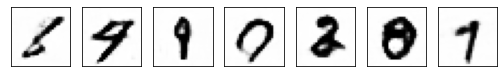

118/118 [==============================] - 39s 332ms/step - d_loss: -1.2581 - g_loss: 11.3229
Epoch 46/100
118/118 [==============================] - ETA: 0s - d_loss: -1.2192 - g_loss: 10.3471epoch 45


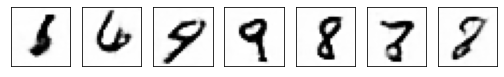

118/118 [==============================] - 39s 332ms/step - d_loss: -1.2145 - g_loss: 10.3570
Epoch 47/100
118/118 [==============================] - ETA: 0s - d_loss: -1.2355 - g_loss: 11.8956epoch 46


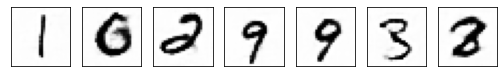

118/118 [==============================] - 39s 331ms/step - d_loss: -1.2468 - g_loss: 11.8701
Epoch 48/100
118/118 [==============================] - ETA: 0s - d_loss: -1.2132 - g_loss: 11.3709epoch 47


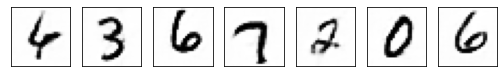

118/118 [==============================] - 39s 331ms/step - d_loss: -1.2035 - g_loss: 11.3707
Epoch 49/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3204 - g_loss: 12.1505epoch 48


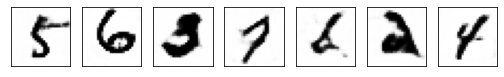

118/118 [==============================] - 39s 331ms/step - d_loss: -1.3294 - g_loss: 12.2076
Epoch 50/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1667 - g_loss: 15.8295epoch 49


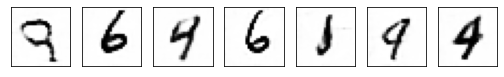

118/118 [==============================] - 39s 332ms/step - d_loss: -1.1874 - g_loss: 15.9159
Epoch 51/100
118/118 [==============================] - ETA: 0s - d_loss: -1.2026 - g_loss: 16.8244epoch 50


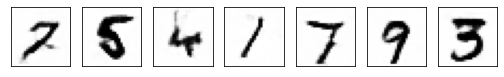

118/118 [==============================] - 39s 331ms/step - d_loss: -1.2336 - g_loss: 16.7965
Epoch 52/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1080 - g_loss: 14.1459epoch 51


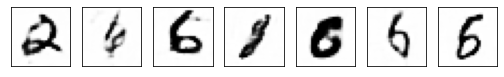

118/118 [==============================] - 39s 334ms/step - d_loss: -1.0824 - g_loss: 14.1404
Epoch 53/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1778 - g_loss: 13.0039epoch 52


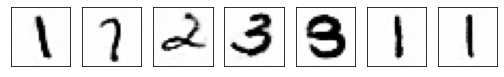

118/118 [==============================] - 39s 332ms/step - d_loss: -1.1966 - g_loss: 13.0107
Epoch 54/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0332 - g_loss: 10.9752epoch 53


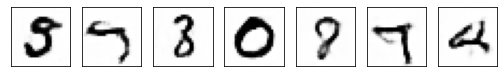

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0324 - g_loss: 10.9513
Epoch 55/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1080 - g_loss: 11.0894epoch 54


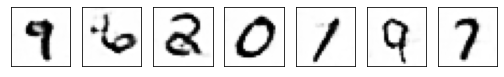

118/118 [==============================] - 39s 331ms/step - d_loss: -1.1179 - g_loss: 11.0908
Epoch 56/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1204 - g_loss: 9.3245epoch 55


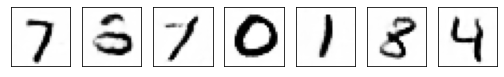

118/118 [==============================] - 39s 332ms/step - d_loss: -1.1251 - g_loss: 9.3269
Epoch 57/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1271 - g_loss: 7.5706epoch 56


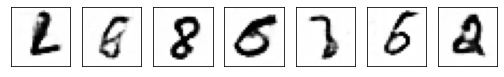

118/118 [==============================] - 39s 332ms/step - d_loss: -1.1226 - g_loss: 7.5621
Epoch 58/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0972 - g_loss: 7.7061epoch 57


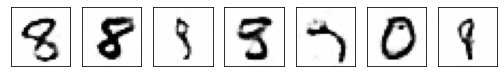

118/118 [==============================] - 39s 332ms/step - d_loss: -1.0766 - g_loss: 7.7267
Epoch 59/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0365 - g_loss: 9.0843epoch 58


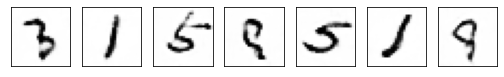

118/118 [==============================] - 39s 333ms/step - d_loss: -1.0410 - g_loss: 9.1160
Epoch 60/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0417 - g_loss: 10.3390epoch 59


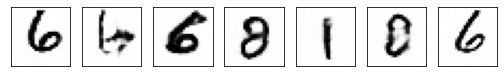

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0416 - g_loss: 10.3442
Epoch 61/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0514 - g_loss: 7.5957epoch 60


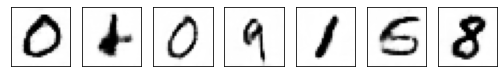

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0491 - g_loss: 7.6132
Epoch 62/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0792 - g_loss: 8.5964epoch 61


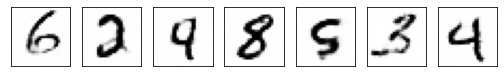

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0797 - g_loss: 8.5980
Epoch 63/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1100 - g_loss: 10.6387epoch 62


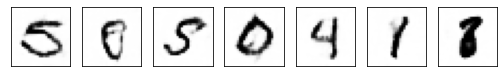

118/118 [==============================] - 39s 332ms/step - d_loss: -1.1180 - g_loss: 10.6598
Epoch 64/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0186 - g_loss: 10.7092epoch 63


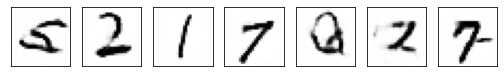

118/118 [==============================] - 39s 332ms/step - d_loss: -1.0176 - g_loss: 10.6830
Epoch 65/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0514 - g_loss: 9.3694epoch 64


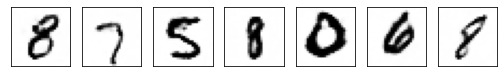

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0728 - g_loss: 9.4380
Epoch 66/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0384 - g_loss: 15.0329epoch 65


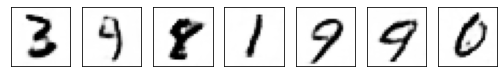

118/118 [==============================] - 39s 332ms/step - d_loss: -1.0153 - g_loss: 15.0227
Epoch 67/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0937 - g_loss: 13.8972epoch 66


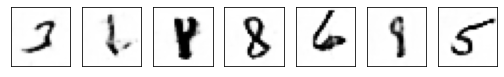

118/118 [==============================] - 39s 334ms/step - d_loss: -1.0587 - g_loss: 13.8798
Epoch 68/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0577 - g_loss: 10.4810epoch 67


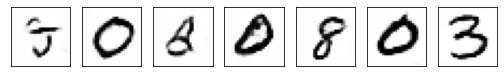

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0666 - g_loss: 10.4788
Epoch 69/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0014 - g_loss: 11.6519epoch 68


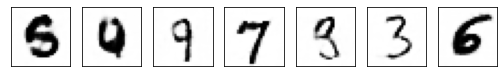

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0059 - g_loss: 11.6528
Epoch 70/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0036 - g_loss: 10.2878epoch 69


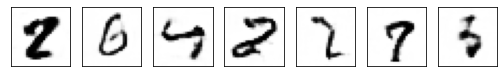

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0159 - g_loss: 10.3272
Epoch 71/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0220 - g_loss: 13.1633epoch 70


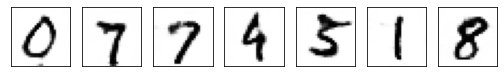

118/118 [==============================] - 39s 332ms/step - d_loss: -1.0166 - g_loss: 13.1314
Epoch 72/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0306 - g_loss: 16.8916epoch 71


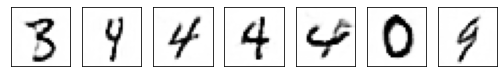

118/118 [==============================] - 39s 332ms/step - d_loss: -1.0355 - g_loss: 16.9352
Epoch 73/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0809 - g_loss: 18.3009epoch 72


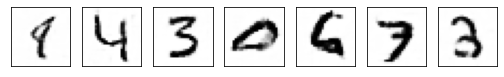

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0926 - g_loss: 18.2434
Epoch 74/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9473 - g_loss: 18.2007epoch 73


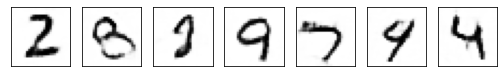

118/118 [==============================] - 39s 332ms/step - d_loss: -0.9532 - g_loss: 18.2346
Epoch 75/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0564 - g_loss: 18.3010epoch 74


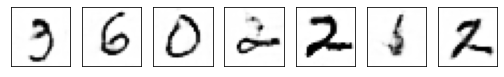

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0731 - g_loss: 18.2900
Epoch 76/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9100 - g_loss: 15.7483epoch 75


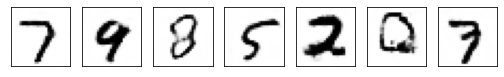

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9187 - g_loss: 15.7310
Epoch 77/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9352 - g_loss: 11.5946epoch 76


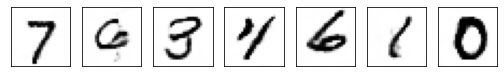

118/118 [==============================] - 39s 332ms/step - d_loss: -0.9470 - g_loss: 11.5792
Epoch 78/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9488 - g_loss: 10.1564epoch 77


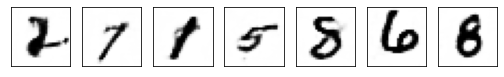

118/118 [==============================] - 39s 332ms/step - d_loss: -0.9419 - g_loss: 10.1758
Epoch 79/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9449 - g_loss: 11.0047epoch 78


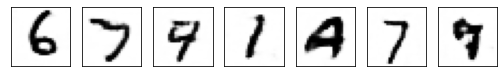

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9472 - g_loss: 10.9993
Epoch 80/100
118/118 [==============================] - ETA: 0s - d_loss: -0.8931 - g_loss: 11.8170epoch 79


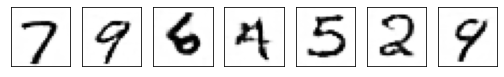

118/118 [==============================] - 39s 331ms/step - d_loss: -0.8429 - g_loss: 11.8276
Epoch 81/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9604 - g_loss: 12.9647epoch 80


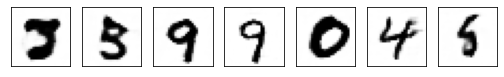

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9696 - g_loss: 13.0084
Epoch 82/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9774 - g_loss: 9.8625epoch 81


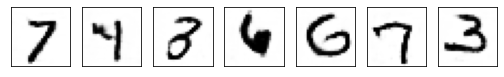

118/118 [==============================] - 39s 332ms/step - d_loss: -0.9777 - g_loss: 9.9132
Epoch 83/100
118/118 [==============================] - ETA: 0s - d_loss: -1.1802 - g_loss: 8.6802epoch 82


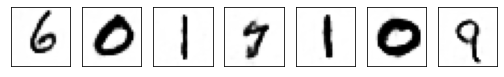

118/118 [==============================] - 39s 331ms/step - d_loss: -1.2413 - g_loss: 8.7225
Epoch 84/100
118/118 [==============================] - ETA: 0s - d_loss: -0.7194 - g_loss: 11.2896epoch 83


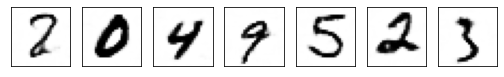

118/118 [==============================] - 39s 331ms/step - d_loss: -0.7323 - g_loss: 11.3052
Epoch 85/100
118/118 [==============================] - ETA: 0s - d_loss: -0.8543 - g_loss: 12.4309epoch 84


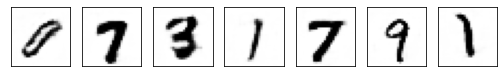

118/118 [==============================] - 39s 331ms/step - d_loss: -0.8641 - g_loss: 12.4060
Epoch 86/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0068 - g_loss: 9.4458epoch 85


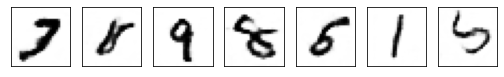

118/118 [==============================] - 39s 331ms/step - d_loss: -1.0343 - g_loss: 9.4376
Epoch 87/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9271 - g_loss: 5.3266epoch 86


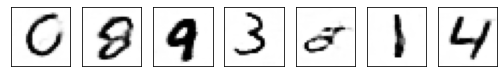

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9321 - g_loss: 5.3487
Epoch 88/100
118/118 [==============================] - ETA: 0s - d_loss: -0.8714 - g_loss: 10.2568epoch 87


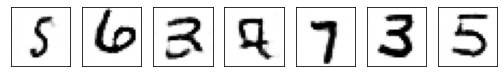

118/118 [==============================] - 39s 330ms/step - d_loss: -0.8622 - g_loss: 10.2843
Epoch 89/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9658 - g_loss: 9.2933epoch 88


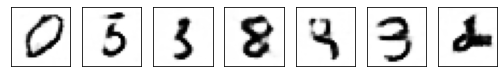

118/118 [==============================] - 39s 333ms/step - d_loss: -0.9700 - g_loss: 9.2817
Epoch 90/100
118/118 [==============================] - ETA: 0s - d_loss: -0.8039 - g_loss: 8.7690epoch 89


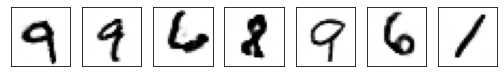

118/118 [==============================] - 39s 331ms/step - d_loss: -0.7826 - g_loss: 8.8006
Epoch 91/100
118/118 [==============================] - ETA: 0s - d_loss: -0.8130 - g_loss: 9.4853epoch 90


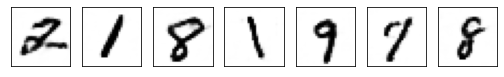

118/118 [==============================] - 39s 331ms/step - d_loss: -0.8262 - g_loss: 9.4894
Epoch 92/100
118/118 [==============================] - ETA: 0s - d_loss: -0.8681 - g_loss: 6.2465epoch 91


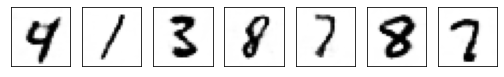

118/118 [==============================] - 39s 331ms/step - d_loss: -0.8818 - g_loss: 6.2609
Epoch 93/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9581 - g_loss: 7.6205epoch 92


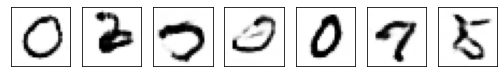

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9482 - g_loss: 7.6323
Epoch 94/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9443 - g_loss: 4.1652epoch 93


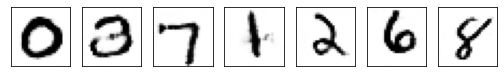

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9538 - g_loss: 4.0981
Epoch 95/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9140 - g_loss: 1.3209epoch 94


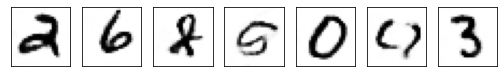

118/118 [==============================] - 39s 332ms/step - d_loss: -0.9052 - g_loss: 1.2958
Epoch 96/100
118/118 [==============================] - ETA: 0s - d_loss: -1.0083 - g_loss: 4.7049epoch 95


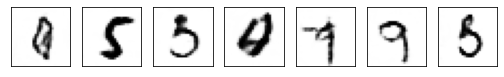

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9981 - g_loss: 4.7007
Epoch 97/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9076 - g_loss: 9.7178epoch 96


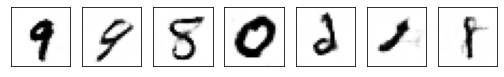

118/118 [==============================] - 39s 333ms/step - d_loss: -0.9107 - g_loss: 9.6962
Epoch 98/100
118/118 [==============================] - ETA: 0s - d_loss: -0.7811 - g_loss: 8.8299epoch 97


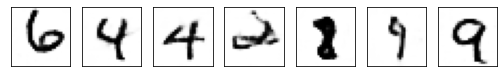

118/118 [==============================] - 39s 331ms/step - d_loss: -0.7744 - g_loss: 8.8226
Epoch 99/100
118/118 [==============================] - ETA: 0s - d_loss: -0.9863 - g_loss: 10.5454epoch 98


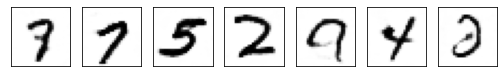

118/118 [==============================] - 39s 331ms/step - d_loss: -0.9773 - g_loss: 10.5294
Epoch 100/100
118/118 [==============================] - ETA: 0s - d_loss: -0.7098 - g_loss: 6.8934epoch 99


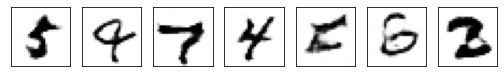

118/118 [==============================] - 39s 331ms/step - d_loss: -0.7186 - g_loss: 6.8693


In [7]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(num_img=8, latent_dim=noise_dim)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])

Display the last generated images:


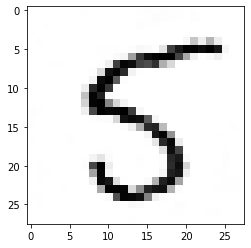

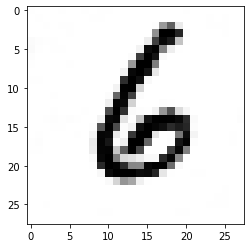

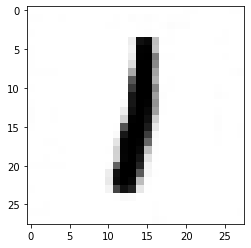

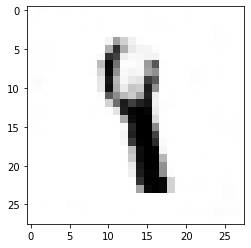

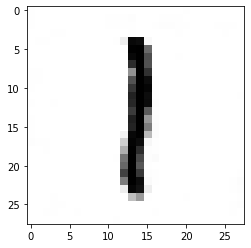

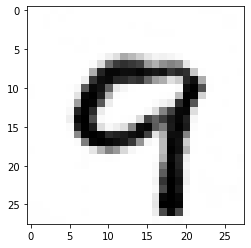

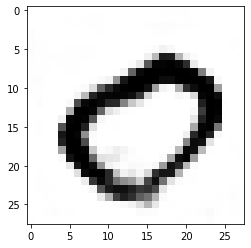

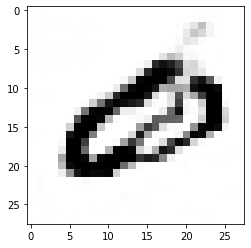

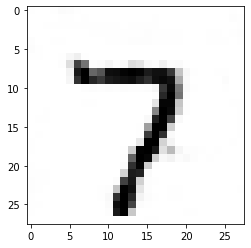

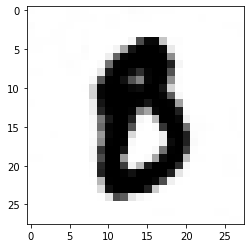

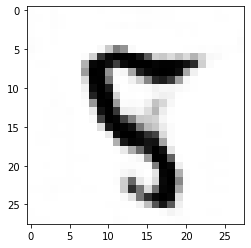

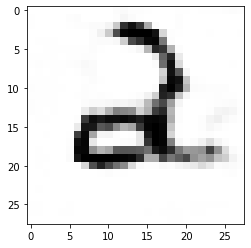

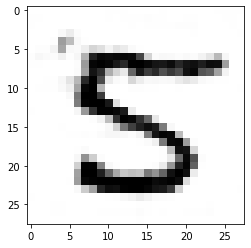

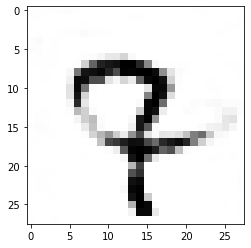

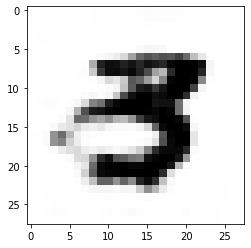

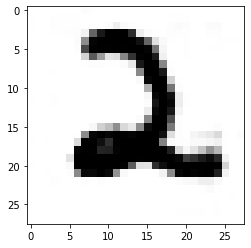

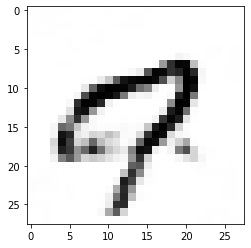

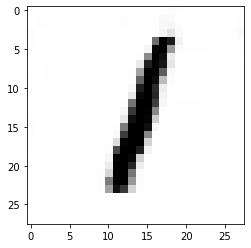

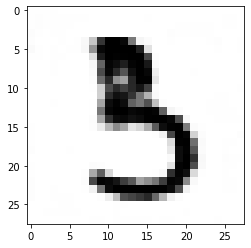

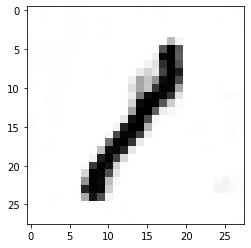

In [8]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(20, noise_dim))

generated_images = wgan.generator(random_latent_vectors)
generated_images = (generated_images * 127.5) + 127.5
for image in generated_images:
  plt.imshow(image.numpy().squeeze(), cmap="binary")
  plt.show()